# Actualización de una media

La media de una variable $x$ se define como:

$$
\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

En esta libreta exploraremos tres formas de actualizar una media cuando obtenemos nueva información:

1. **Actualización aritmética**, usando solo operaciones básicas sin guardar los datos originales.
2. **Actualización exacta bayesiana**, usando una fórmula cerrada para combinar dos fuentes de información.
3. **Actualización bayesiana con MCMC**, estimando la distribución posterior mediante simulación.


## Parte 1: Actualización aritmética

Supongamos que tenemos una media calculada previamente:  
$\bar{x} = 1612.123456789$ con $n = 1,232,534$

Ahora recibimos un nuevo dato: $x_{n+1} = 322$  
Recalcular la media con todos los datos puede ser costoso, pero hay una forma de actualizar la media sin necesidad de acceder al arreglo original:

$$
\bar{x}_{n+1} = \frac{n \cdot \bar{x}_n + x_{n+1}}{n + 1}
$$

Esto nos permite incorporar el nuevo valor eficientemente, sin necesidad de almacenar toda la muestra.




In [1]:
def actualizar_media(
    media_anterior: float, 
    n_anterior: int, 
    nuevo_valor: float
) -> float:
    """
    Actualiza la media al incorporar un nuevo dato, sin necesidad de guardar todos los datos originales.

    Parámetros
    ----------
    media_anterior : float
        Media calculada previamente.
    n_anterior : int
        Tamaño muestral previo.
    nuevo_valor : float
        Nuevo dato a incorporar.

    Retorna
    -------
    float
        Nueva media actualizada.
    """
    media_actualizada =  (n_anterior * media_anterior + nuevo_valor) / (n_anterior + 1)
    return media_actualizada
print('Función definida')


Función definida


In [2]:
media_anterior = 1612.1234567890
n = 1_232_534
dato_nuevo = 322

media_actualizada = actualizar_media(media_anterior, n, dato_nuevo)
print('La media actualizada es:', media_actualizada)

La media actualizada es: 1612.1224100654126


## Parte 2: Actualización bayesiana exacta

En contextos reales, muchas veces no conocemos todos los datos, pero sí tenemos información resumida de estudios previos (media, desviación estándar y tamaño de muestra).

La estadística bayesiana nos permite actualizar nuestra estimación de la media poblacional al combinar dos fuentes de información. Si consideramos que la media tiene una distribución normal, y que no conocemos la varianza poblacional con certeza, usamos una distribución t de Student como distribución posterior.

La forma general es:

$$
\mu \mid \text{datos} \sim t_{\nu_n}(\mu_n, \frac{s_n^2}{\kappa_n})
$$

Donde los parámetros se actualizan así:

$$\mu_n = \frac{\kappa_0 \mu_0 + \kappa_1 \bar{x}_1}{\kappa_0 + \kappa_1}$$
$$s_n^2 = \frac{ (\nu_0 s_0^2 + \nu_1 s_1^2) + \frac{\kappa_0 \kappa_1}{\kappa_0 + \kappa_1}(\mu_0 - \bar{x}_1)^2 }{\nu_0 + \nu_1}$$
$$\kappa_n = \kappa_0 + \kappa_1$$
$$\nu_n = \nu_0 + \nu_1$$

**Parámetros**:

- $\mu_0$, $s_0$, $n_0$: media, desviación estándar y tamaño de muestra del estudio previo
- $\bar{x}_1$, $s_1$, $n_1$: media, desviación estándar y tamaño de muestra del nuevo estudio
- $\kappa = n$ y $\nu = n - 1$

Este enfoque es útil cuando queremos combinar estudios anteriores con nueva evidencia de forma rigurosa, sin asumir varianza conocida.



In [3]:
def actualizar_media_bayesiana_exacta(
    media0: float, sd0: float, n0: int,
    media1: float, sd1: float, n1: int
) -> dict:
    """
    Actualiza una estimación de la media combinando dos estudios mediante fórmula bayesiana exacta
    bajo suposición de varianza desconocida (posterior t de Student).

    Parámetros
    ----------
    media0 : float
        Media del estudio previo.
    sd0 : float
        Desviación estándar del estudio previo.
    n0 : int
        Tamaño de muestra del estudio previo.
    media1 : float
        Media del nuevo estudio.
    sd1 : float
        Desviación estándar del nuevo estudio.
    n1 : int
        Tamaño de muestra del nuevo estudio.

    Retorna
    -------
    dict
        Diccionario con los parámetros de la distribución posterior:
        - 'media_posterior' (float)
        - 'varianza_posterior' (float)
        - 'kappa_posterior' (float)
        - 'gl_posterior' (int)
    
    Notas
    -----
    El índice 0 indica el estudio previo, 1 el actual, y "p" la actualización posterior.
    """
    kappa_0 = n0
    kappa_1 = n1

    var0 = sd0 ** 2
    var1 = sd1 ** 2

    kappa_p = kappa_0 + kappa_1

    gl0 = n0 - 1
    gl1 = n1 - 1
    gl_p = gl0 + gl1

    mu_p = (kappa_0 * media0 + kappa_1 * media1) / kappa_p

    var_p = (
        gl0 * var0 +
        gl1 * var1 +
        (kappa_0 * kappa_1 / kappa_p) * (media0 - media1) ** 2
    ) / gl_p

    return {
        'mu_posterior': mu_p,
        'sigma_posterior': var_p**0.5,
        'kappa_posterior': kappa_p,
        'gl_posterior': gl_p
    }

print('Función definida')

Función definida


In [4]:
# Datos del estudio previo
media0 = 110
sd0 = 17
n0 = 115

# Datos del nuevo estudio
media1 = 95
sd1 = 15
n1 = 78

# Actualización
resultado = actualizar_media_bayesiana_exacta(media0, sd0, n0, media1, sd1, n1)

# Visualización
for k, v in resultado.items():
    print(f"{k}: {v:.2f}")


mu_posterior: 103.94
sigma_posterior: 17.83
kappa_posterior: 193.00
gl_posterior: 191.00


## Parte 3: Actualización bayesiana con MCMC

Otra alternativa moderna y flexible es utilizar simulación Monte Carlo con cadenas de Markov (MCMC) para obtener la distribución posterior de un parámetro de interés.

Este método producirá la estimación posterior de los parámetros y a pesar de que es más costoso computacionalmente y su precisión depende del número de muestras y la convergencia, pero permite mayor flexibilidad cuando no es posible usar una fórmula cerrada

Usando herramientas como `bambi` (una interfaz bayesiana de alto nivel sobre `pymc`), podemos especificar un modelo simple para inferir la media del nuevo estudio condicionado a los datos observados y al conocimiento previo sobre el parámetro.

Este enfoque es útil cuando se cuenta con datos individuales solo del estudio actual, pero se dispone de un resumen estadístico del estudio previo. El resultado es una estimación posterior de la media del nuevo estudio, ponderada por la confianza en la información previa.

### Librerías


In [5]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
print('Librerías importadas')

Librerías importadas


### Datos y modelo
El modelo que especificaremos seguirá la siguiente forma.

```python
model = bmb.Model('X ~ 1', data, family='t')
result = model.fit(priors=...)
```
En la fórmula solo necesitamos el intercepto de la variable $x$. Los parámetros que obtendremos será el **Intercepto** que representa la media, **Sigma** que es la desviación estándar y **nu** que son los grados de libertad porque utilizamos la distribución t.



In [ ]:

# Usaremos los mismos parámetros de la parte 2
# Simulamos los datos del estudio actual
np.random.seed(42)
n = 78
datos = pd.DataFrame({
    "X": np.random.normal(loc=95, scale=15, size=n) # los parámetros reales van a ser diferentes.
})

# Simulamos datos del estudio previo.
mu0 = 110
sd0 = 17
n0 = 115
prior_sd_mu = sd0 / np.sqrt(n0) # "sd" en el nombre de la variable,
                                # es sampling distribution

# Constuimos y ajustamos el modelo
priors ={
    "Intercept": bmb.Prior("Normal", mu=mu0, sigma=prior_sd_mu), # media
    "sigma": bmb.Prior("HalfNormal", sigma=sd0), # desv. est.
}
model = bmb.Model(
    "X ~ 1", # solo incluimos el intercepto
    data=datos,
    family='t',
    priors=priors
)
model

       Formula: X ~ 1
        Family: t
          Link: mu = identity
  Observations: 78
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 110.0, sigma: 1.5853)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
            sigma ~ HalfNormal(sigma: 17.0)

### Ajuste del modelo
Ahora ajustaremos los datos al modelo. Puedes ajustar el número de cadenas y núcleos, se sugiere utilizar al menos 4 cadenas.

Es probable que veas advertencias al correr el siguiente código, como las que puedes ver aquí, esto se debe a la forma en que realizamos la instalación pero para fines de este curso, no alteran nuestros resultados así que puedes omitirlas.

In [7]:
resultado_mcmc = model.fit()
print('Resultados listos')

Initializing NUTS using jitter+adapt_diag...
C:\Users\User\Documents\coding\curso_python\.venv\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, Intercept]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Resultados listos


### Inspección del resultado

Antes de que analicemos los resultados del modelo, inspeccionemos si las cadenas convergieron adecuadamente.
Cuando ejecutes el código, en tu libreta podrás ver el proceso de muestreo del MCMC (método Montecarlo con Cadenas Markov), y deberías ver que no se encontraron divergencias durante el proceso .
Veamos ahora la traza.


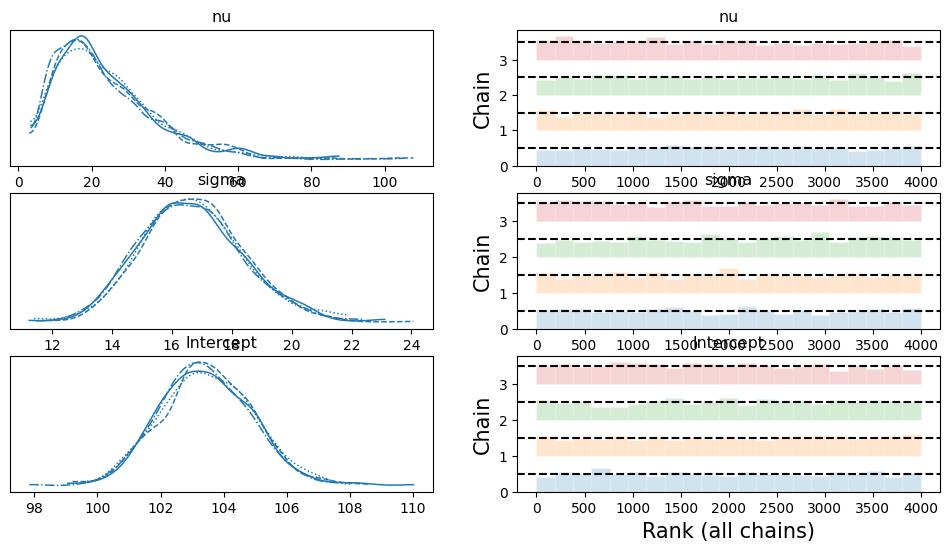

In [8]:
az.plot_trace(resultado_mcmc, kind='rank_bars');

Podemos ver que las distribuciones del intercepto y de sigma son razonablemente normales y no existen divergencias importantes en las cadenas, solo nu es asimétrica pero es esperado porque son los grados de libertad.

### Resultados

In [9]:
resumen_mcmc = az.summary(resultado_mcmc, hdi_prob=0.95)
resumen_mcmc

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,24.268,14.170,3.380,51.942,0.224,0.319,3758.0,2525.0,1.0
sigma,16.691,1.724,13.441,20.207,0.034,0.025,2599.0,2674.0,1.0
Intercept,103.446,1.437,100.694,106.213,0.026,0.020,3014.0,3143.0,1.0


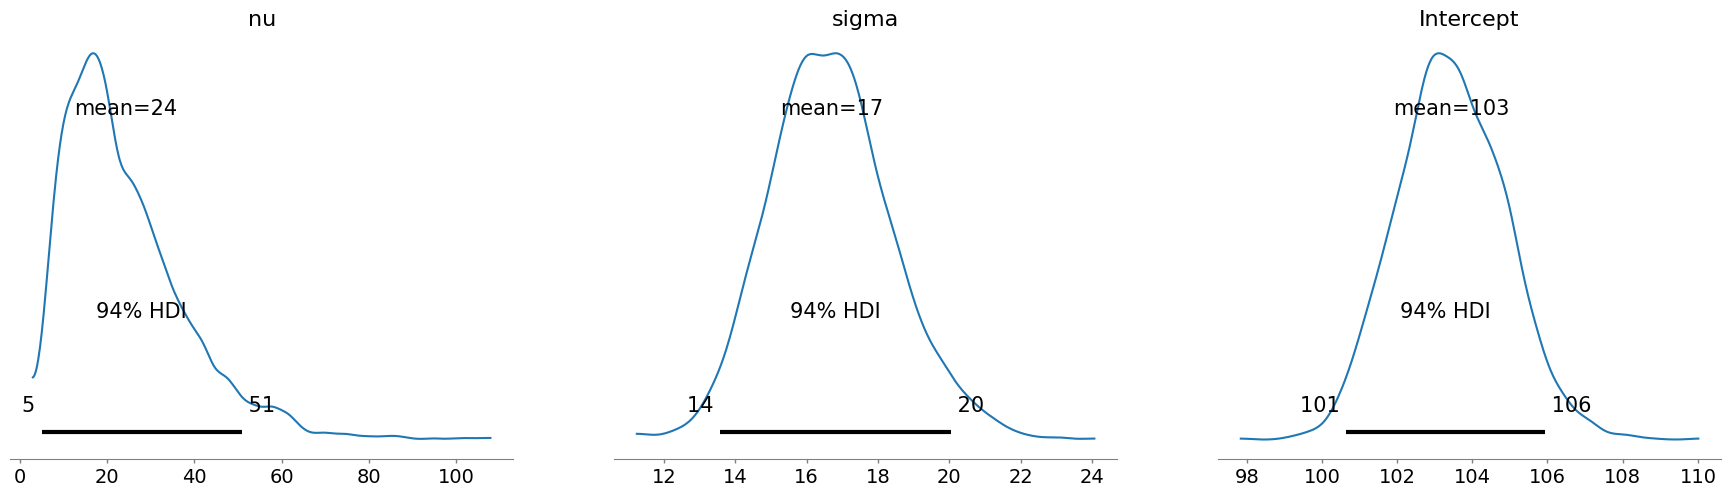

In [10]:
az.plot_posterior(resultado_mcmc);

Como vemos actualizamos los parámetros del estudio con base en datos previos. Veamos cómo se veían los parámetros en nuestros datos antes de la actualización.
### Comparación de los métodos

In [11]:
print(f'media previa \t= {mu0}')
print(f"media_empirica \t= {datos['X'].mean():.2f}")
print(f"media_exacta \t= {resultado['mu_posterior']:.2f}")
print(f"media_mcmc \t= {resumen_mcmc.loc['Intercept', 'mean']:.2f}")


media previa 	= 110
media_empirica 	= 93.46
media_exacta 	= 103.94
media_mcmc 	= 103.45
